In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch.nn import MSELoss
from torchvision.utils import make_grid
from dataclasses import dataclass
from typing import Dict, Tuple
from torch.utils.data import DataLoader

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## TODO
- [X] 1. Generate captions for dataset using pre-trained VLM
- [ ] 2. Use pre-trained text encoder as sub model
- [ ] 3. Modify model to add cross attention
- [ ] 4. Update training step to make use of text encoder

## Training Config - Your knobs

In [2]:
@dataclass
class TrainingConfig:
    dataset: str = "reese-green/afhq64_captions_64k"
    label_key: str = "caption_paligemma-3b-mix-224"
    # Model architecture
    resolution: int = 32 # resolution of the image
    num_denoising_steps: int = 1000 # number of timesteps

    # Training loop and optimizer
    total_steps: int = 100000  # total number of training steps
    # batch_size: int = 32 # batch size
    batch_size: int = 1 # batch size

    learning_rate: float = 5e-4 # initial learning rate
    weight_decay: float = 1e-6 # weight decay

    # Data augmentation
    random_flip: bool = False # randomly flip images horizontally


config = TrainingConfig(resolution=32)

## Load data

In [3]:
from src.datasets.hugging_face_dataset import HuggingFaceDataset


def load_data(config: TrainingConfig) -> Tuple[DataLoader, DataLoader]:
    resolution = config.resolution
    transforms_list = [
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
    if config.random_flip:
        transforms_list.insert(0, transforms.RandomHorizontalFlip())

    transform = transforms.Compose(transforms_list)
    train_dataset = HuggingFaceDataset(config.dataset, split="train", label_key=config.label_key, transform=transform)
    val_dataset = HuggingFaceDataset(config.dataset, split="val", label_key=config.label_key, transform=transform)

    train_dataloader = DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
    )

    return train_dataloader, val_dataloader

train_dataloader, val_dataloader = load_data(config)


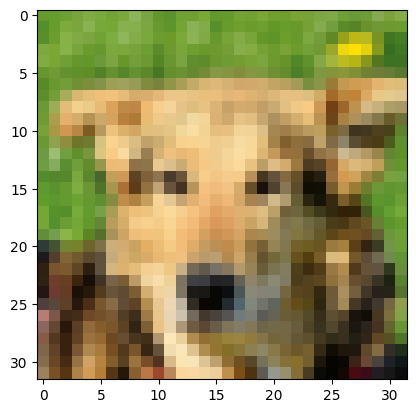

In [4]:
x = next(iter(train_dataloader))

from matplotlib import pyplot as plt
grid_img = make_grid(x[0]).permute(1, 2, 0)
grid_img = (grid_img - grid_img.min()) / (grid_img.max() - grid_img.min())
plt.imshow(grid_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


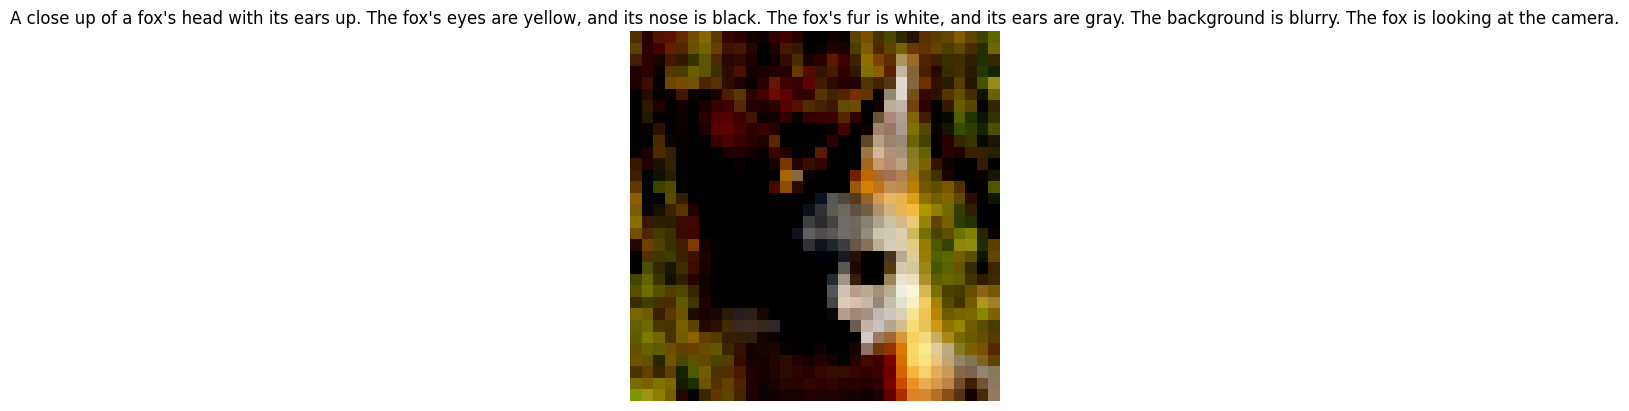

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


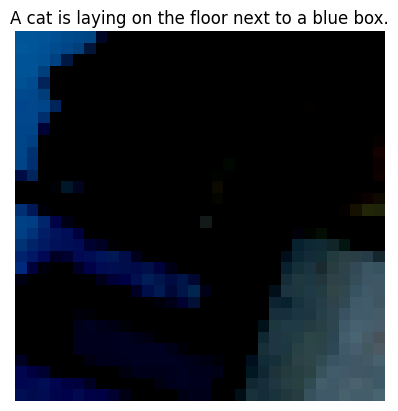

In [5]:
x = next(iter(val_dataloader))

# show two random examples of images and captions
import random
import matplotlib.pyplot as plt

def show_random_images(dataloader, n_images=2):
    for _ in range(n_images):
        idx = random.randint(0, len(dataloader.dataset))
        image, caption = dataloader.dataset[idx]
        plt.imshow(image.permute(1, 2, 0))
        plt.title(caption)
        plt.axis("off")
        plt.show()

show_random_images(train_dataloader)


## Create model components for diffusion

### Library code for model architecture

### Create model (the user logic)

In [6]:
from src.models.unet.unet_model import UNet

device = torch.device("cuda")
denoising_model = UNet(
    image_size=config.resolution,
).to(device)

print(f"model params: {sum(p.numel() for p in denoising_model.parameters()) / 1e6:.2f} M")

model params: 14.42 M


### Optimizer

In [7]:
optimizer = optim.AdamW(denoising_model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

### Diffusion noise schedule

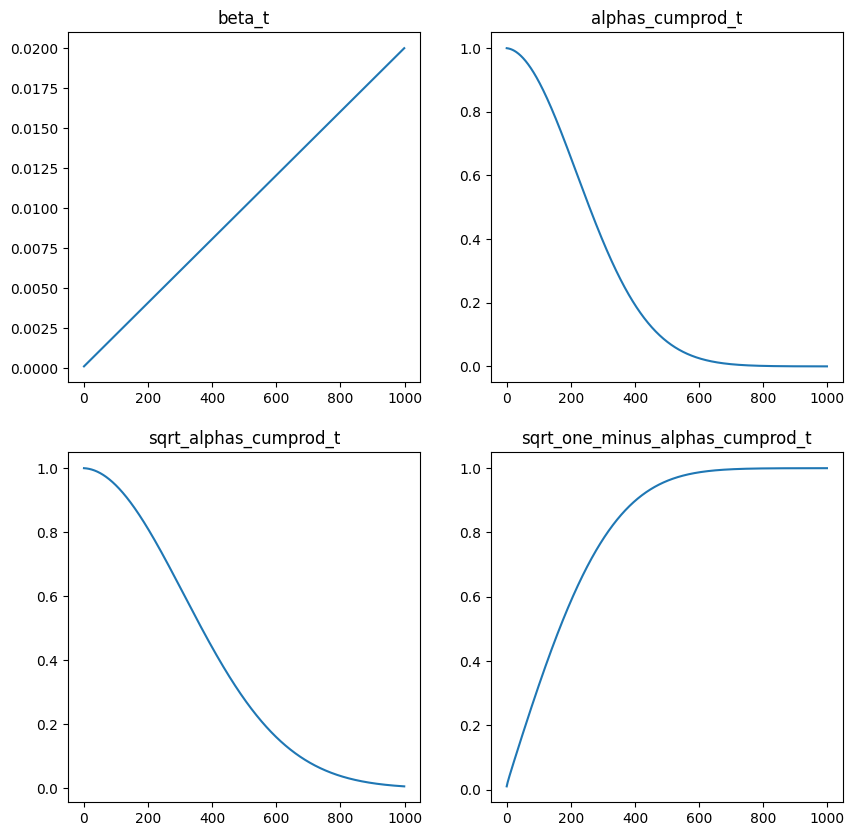

In [8]:
beta_min, beta_max = 1e-4, 0.02
# beta_min, beta_max = 1e-4, 1
# beta_min, beta_max = 0, 0.02

def create_noise_schedule(n_T: int, device: torch.device) -> Dict[str, torch.Tensor]:
    betas = torch.linspace(beta_min, beta_max, n_T).to(device)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0).to(device)
    alphas_cumprod_prev = torch.cat([torch.ones(1).to(device), alphas_cumprod[:-1].to(device)])
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas).to(device)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "betas": betas,
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance,
    }


noise_schedule = create_noise_schedule(config.num_denoising_steps, device)

# plot the schedule
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1); plt.plot(range(1000), noise_schedule["betas"].cpu().numpy())
plt.title("beta_t")

plt.subplot(2, 2, 2); plt.plot(range(1000), noise_schedule["alphas_cumprod"].cpu().numpy())
_ = plt.title("alphas_cumprod_t")

plt.subplot(2, 2, 3); plt.plot(range(1000), noise_schedule["sqrt_alphas_cumprod"].cpu().numpy())
plt.title("sqrt_alphas_cumprod_t")

plt.subplot(2, 2, 4); plt.plot(range(1000), noise_schedule["sqrt_one_minus_alphas_cumprod"].cpu().numpy())
_ = plt.title("sqrt_one_minus_alphas_cumprod_t")

## Train




### Forward diffusion

Forward diffusion can be considered as "data augmentation" in the training step. It adds noise to the data to challenge the model to be able to tell apart signal from noise. Diffusion is a particular way of adding noise, with much mathematical rigor.

In [9]:
# Model components
def forward_diffusion(x_0, t, noise_schedule, noise=None):
    _ts = t.view(-1, 1, 1, 1)
    if noise is None:
        noise = torch.randn_like(x_0)
    assert _ts.max() < len(noise_schedule["alphas_cumprod"]), f"t={_ts.max()} is larger than the length of noise_schedule: {len(noise_schedule['alphas_cumprod'])}"
    alpha_prod_t = noise_schedule["alphas_cumprod"][_ts]
    x_t = (alpha_prod_t ** 0.5) * x_0 + ((1 - alpha_prod_t) ** 0.5) * noise
    return x_t, noise


### Visualizing forward diffusion on an image

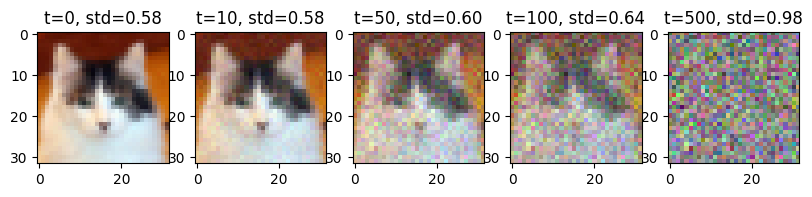

In [10]:
# Let's see what forward diffusion does.
x_0, _ = next(iter(val_dataloader))
x_0 = x_0.to(device)
x_t_list = []
common_noise = torch.randn_like(x_0)
# print(f"x_0 std:", x_0[0].std().item())

noise_levels = [0, 10, 50, 100, 500]
for t in noise_levels:
  t = torch.full((x_0.shape[0],), t, device=device)
  x_t_list.append(forward_diffusion(x_0, t, noise_schedule, noise=common_noise)[0])

# visualize
plt.figure(figsize=(20, 5))
for i, (t, x_t) in enumerate(zip(noise_levels, x_t_list)):
  # print(x_t[0].min().item(), x_t[0].max().item())
  plt.subplot(1, 10, i+1)
  plt.title(f"t={t}, std={x_t[0].std():.2f}")
  img = x_t[0].cpu().numpy().transpose(1, 2, 0)
  img = (img - img.min()) / (img.max() - img.min())
  plt.imshow(img)
  if i >= 10:
    break


### Training loop

In [ ]:
from tqdm.auto import tqdm
import itertools
from transformers import CLIPModel, CLIPProcessor

criterion = MSELoss()
denoising_model.train()

def train(denoising_model, steps=100):

# Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the processor and model
    processor = CLIPProcessor.from_pretrained("zer0int/CLIP-GmP-ViT-L-14")
    model = CLIPModel.from_pretrained("zer0int/CLIP-GmP-ViT-L-14").to(device)

    print("Training on device:", device)
    max_train_steps = steps

    train_progress_bar = tqdm(enumerate(itertools.cycle(train_dataloader)))

    num_examples = 0
    for step, (x_0, text) in train_progress_bar:
        x_0 = x_0.to(device)  # x_0 is the clean data to teach the model to generate
        optimizer.zero_grad()

        noise = torch.randn(x_0.shape).to(device)
        t = torch.randint(0, config.num_denoising_steps, (x_0.shape[0],), device=device).long()
        x_t, true_noise = forward_diffusion(x_0, t, noise_schedule, noise=noise)

        # Tokenize the text
        inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True).to(device)

        # Get text embeddings
        with torch.no_grad():
            text_features = model.get_text_features(**inputs)
        
        # TODO: Need to have Batch sequence, sequence length, hidden_dim
        text_features = text_features.unsqueeze(1)
        # repeat axis=1 32 times
        text_features = text_features.repeat(1, 32, 1)
        print(f"text_features shape: {text_features.shape}")

        predicted_noise = denoising_model(t=t, x=x_t, context=text_features)

        loss = criterion(predicted_noise, true_noise)
        loss.backward();
        # torch.nn.utils.clip_grad_norm_(denoising_model.parameters(), 1)  # try commenting it out
        optimizer.step()

        train_progress_bar.set_postfix({"loss": loss.cpu().item()})
        num_examples += len(x_0)

        if step >= max_train_steps:
            print(f"Reached the max training steps:", max_train_steps)
            break

    print(f"Trained on {num_examples} examples.")
    return loss


loss = train(denoising_model, steps=100)

2024-12-11 15:13:16.096646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 15:13:16.165589: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 15:13:16.434027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2024-12

Training on device: cuda


0it [00:00, ?it/s]

text_features shape: torch.Size([1, 1, 768])
type of module: <class 'src.models.unet.timestep.TimestepEmbedSequential'>
layer: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
type of module: <class 'src.models.unet.timestep.TimestepEmbedSequential'>
context.shape: torch.Size([1, 1, 768])


RuntimeError: Expected number of channels in input to be divisible by num_groups, but got input of shape [1, 1, 768] and num_groups=32

## Generate

### The sampling algo

In [ ]:
def denoising_step(denoising_model, x_t, t, noise_schedule, thresholding=False, clip_sample=True, clip_sample_range=1.0):
    """
    This is the backward diffusion step, with the effect of denoising.
    """
    if isinstance(t, int):
        t_tensor = torch.full((x_t.shape[0],), t, device=x_t.device)
    else:
        t_tensor = t
    with torch.no_grad():
        model_output = denoising_model(t=t_tensor, x=x_t)
    if hasattr(model_output, "sample"):
        model_output = model_output.sample

    # Extract relevant values from noise_schedule
    alpha_prod_t = noise_schedule["alphas_cumprod"][t_tensor]
    # deal with t=0 case where t can be a tensor
    alpha_prod_t_prev = torch.where(t_tensor > 0,
                                    noise_schedule["alphas_cumprod"][t_tensor - 1],
                                    torch.ones_like(t_tensor, device=x_t.device))

    # Reshape alpha_prod_t_prev for proper broadcasting
    alpha_prod_t = alpha_prod_t.view(-1, 1, 1, 1)
    alpha_prod_t_prev = alpha_prod_t_prev.view(-1, 1, 1, 1)

    beta_prod_t = 1 - alpha_prod_t
    beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t

    # Compute the previous sample mean
    pred_original_sample = (x_t - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5

    if clip_sample:
        pred_original_sample = torch.clamp(pred_original_sample, -clip_sample_range, clip_sample_range)

    # Compute the coefficients for pred_original_sample and current sample
    pred_original_sample_coeff = (alpha_prod_t_prev ** 0.5 * current_beta_t) / beta_prod_t
    current_sample_coeff = current_alpha_t ** 0.5 * beta_prod_t_prev / beta_prod_t

    # Compute the previous sample
    pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * x_t

    # Add noise
    variance = torch.zeros_like(x_t)
    variance_noise = torch.randn_like(x_t)

    # Handle t=0 case where t can be a tensor
    non_zero_mask = (t_tensor != 0).float().view(-1, 1, 1, 1)
    variance = non_zero_mask * ((1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t)
    variance = torch.clamp(variance, min=1e-20)

    pred_prev_sample = pred_prev_sample + (variance ** 0.5) * variance_noise

    return pred_prev_sample


def denoising_step_direct(
    denoising_model,
    x_t,
    t,
    noise_schedule,
    clip_sample=True,
    clip_sample_range=1.0,
):
    """
    This is the backward diffusion step, with the effect of denoising.
    """
    if isinstance(t, int):
        t_tensor = torch.full((x_t.shape[0],), t, device=x_t.device)
    else:
        t_tensor = t

    with torch.no_grad():
        eps_theta = denoising_model(t=t_tensor, x=x_t)
    if hasattr(eps_theta, "sample"):
        eps_theta = eps_theta.sample

    # Extract alphas from noise schedule
    alpha_t = noise_schedule["alphas"][t_tensor]
    alpha_t_cumprod = noise_schedule["alphas_cumprod"][t_tensor]

    # Reshape for broadcasting
    view_shape = (-1,) + (1,) * (x_t.ndim - 1)
    alpha_t = alpha_t.view(*view_shape)
    alpha_t_cumprod = alpha_t_cumprod.view(*view_shape)

    # Calculate epsilon factor
    eps_factor = (1 - alpha_t) / (1 - alpha_t_cumprod).sqrt()

    # Calculate mean for reverse process
    mean = (1 / torch.sqrt(alpha_t)) * (x_t - eps_factor * eps_theta)

    # Apply clipping
    # if clip_sample:
    #     mean = torch.clamp(mean, -clip_sample_range, clip_sample_range)

    # Add noise scaled by variance for non-zero timesteps
    noise = torch.randn_like(x_t)
    beta_t = 1 - alpha_t
    variance = beta_t * (1 - alpha_t_cumprod / alpha_t) / (1 - alpha_t_cumprod)
    variance = torch.clamp(variance, min=1e-20)  # Add clamp to prevent numerical instability
    
    # Mask out noise for t=0 timesteps
    non_zero_mask = (t_tensor > 0).float().view(*view_shape)
    noise_scale = torch.sqrt(variance) * non_zero_mask
    
    pred_prev_sample = mean + noise_scale * noise

    # Apply clipping
    if clip_sample:
        pred_prev_sample = torch.clamp(pred_prev_sample, -clip_sample_range, clip_sample_range)

    return pred_prev_sample

def generate_samples_by_denoising(denoising_model, x_T, noise_schedule, n_T, device, thresholding=False, clip_sample=True, clip_sample_range=1.0, seed=0, method="direct"):
    """
    This is the generation process.
    """
    torch.manual_seed(seed)

    x_t = x_T.to(device)
    pbar = tqdm(range(n_T - 1, -1, -1))
    for t in pbar:
        if method == "direct":
            x_t = denoising_step_direct(denoising_model, x_t, t, noise_schedule, clip_sample, clip_sample_range)
        else:
            x_t = denoising_step(denoising_model, x_t, t, noise_schedule, thresholding, clip_sample, clip_sample_range)
        pbar.set_postfix({"std": x_t.std().item()})

    # print("raw x_t range", x_t.min(), x_t.max())
    x_t = (x_t / 2 + 0.5).clamp(0, 1)
    # print("after clamp", x_t.min(), x_t.max())
    return x_t

### Visualize sampled images

In [ ]:
# visualize the sampled images
def visualize_sampled_images(method=None):
  print("Loss of the denoising model:", loss.item())
  x_T = torch.randn(16, 3, 32, 32)
  x_sampled = generate_samples_by_denoising(
    denoising_model, x_T,
    noise_schedule, n_T=1000,
    device=device,
    clip_sample=True,
    clip_sample_range=1.0,
    method=method,
  )
  x_sampled = (x_sampled * 255)

  sampled = make_grid(x_sampled).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
  _ = plt.imshow(sampled)


visualize_sampled_images(method="direct")

In [ ]:
visualize_sampled_images()

### Train some more

In [ ]:
# Train some more
loss = train(denoising_model, steps=1000)
print("loss:", loss.item())

In [ ]:
visualize_sampled_images()

In [ ]:
visualize_sampled_images(method="direct")

### Train even more

In [ ]:
for g in optimizer.param_groups:
    g['lr'] = 1e-4  # reduce learning rate
loss = train(denoising_model, steps=5000)
print("loss:", loss.item())
visualize_sampled_images()

### And, some more

In [ ]:
for g in optimizer.param_groups:
    g['lr'] = 1e-4  # reduce learning rate
loss = train(denoising_model, steps=10000)
print("loss:", loss.item())
visualize_sampled_images()